#### Import statements for the necessary libraries

In [42]:
#imports 

import pygame
import random
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pandas import *
import os
import glob
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
from PIL import Image 

## Specify all variables

##### If save_images is true, the program will save images of tissue types instead of deleting them. This may mess up results if you run the program multiple times without deleting the images before creating a new phantom.

In [43]:
save_images = False
redraw_image = True

#### For setting Mean Effective Energy

In [44]:
anode = 'sn' #ANODE OPTIONS: ag, sn, pt
filter = 'cu' #FILTER OPTIONS: pb, cu, zn, none
filter_thickness = 0.01 #cm
kV = 120 #kV RANGE: 0-150

#### For source and detector functions: 

In [45]:
object_width = 25 # width of object in cm (this will deterine pixel size)

source_distance = 2 # distance from source to object -- CANNOT BE 0
detector_distance = 10 # distance from object to detector -- CANNOT BE 0

source_a = 0.5 # exponential decay constant for source blur

structured_detector = True # True if using a structured detector (detector blur is a rectangular function)
detector_a = 0.1 # exponential decay constant for detector blur if using an exponential function for the detector
detector_crystal_width = .1 # width of detector crystal if using a rectangular function for the detector

print("M = ", (source_distance+detector_distance)/source_distance) # magnification factor = source to detector distance / source to object distance

M =  6.0


#### For noise:

In [46]:
fluence_lambda = 300 # Average number of x-rays per pixel

## Step 1: Create your phantom

In [47]:
if redraw_image:
    image = Image.open('legend.jpg')
    image.show()

    #setting phantom size
    phantom_width = 256
    phantom_height = 256
    
    # Making canvas
    screen = pygame.display.set_mode((phantom_width, phantom_height))
    screen.fill((255, 255, 255)) # Filling Background with white
    
    # Setting Title
    pygame.display.set_caption('Draw your phantom')
    
    
    draw_on = False
    last_pos = (0, 0)
    color = (255, 255, 255)  # Initial Color of the Brush
    phase = "air" # Initial Color of the Brush
    
    # Radius of the Brush
    radius = 5
    
    
    def roundline(canvas, color, start, end, radius=1):
        Xaxis = end[0]-start[0]
        Yaxis = end[1]-start[1]
        dist = max(abs(Xaxis), abs(Yaxis))
        for i in range(dist):
            x = int(start[0]+float(i)/dist*Xaxis)
            y = int(start[1]+float(i)/dist*Yaxis)
            pygame.draw.circle(canvas, color, (x, y), radius)
    
    #tissue options: blood, bone,   air,     skeletal muscle,  soft tissue, lung tissue, breast tissue, brain, tumor
            #colors: red,   grey,   white,   orange,           yellow,     purple,     pink,            brown, black
            #letters: r,    g,      w,       o,                y,          u,          p,               b,     k

    try:
        while True:

            e = pygame.event.wait()

            if e.type == pygame.QUIT:
                raise StopIteration

            #when r is pressed it will change the brush color to red to represent blood
            if e.type == pygame.KEYDOWN:
                if e.key == pygame.K_r:
                    color = (255, 0, 0)
                    phase = "blood"

            #when g is pressed it will change the brush color to gray to represent bone
                if e.key == pygame.K_g:
                    color = (128, 128, 128)
                    phase = "bone"


            #when w is pressed it will change the brush color to white to represent air
                if e.key == pygame.K_w:
                    color = (255, 255, 255)
                    phase = "air"

            #when o is pressed it will change the brush color to orange to represent skeletal muscle
                if e.key == pygame.K_o:
                    color = (255, 165, 0)
                    phase = "muscle"

            #when y is pressed it will change the brush color to yellow to represent soft tissue
                if e.key == pygame.K_y:
                    color = (255, 255, 0)
                    phase = "tissue"

            #when u is pressed it will change the brush color to purple to represent lung tissue
                if e.key == pygame.K_u:
                    color = (128, 0, 128)
                    phase = "lung"

            #when p is pressed it will change the brush color to pink to represent breast tissue
                if e.key == pygame.K_p:
                    color = (255, 192, 203)
                    phase = "breast"

            #when b is pressed it will change the brush color to brown to represent brain
                if e.key == pygame.K_b:
                    color = (165, 42, 42)
                    phase = "brain"

            #when k is pressed it will change the brush color to black to represent tumor
                if e.key == pygame.K_k:
                    color = (0, 0, 0)
                    phase = "tumor"

            #if a number key is pressed
                if e.key == pygame.K_1 or e.key == pygame.K_2 or e.key == pygame.K_3 or e.key == pygame.K_4 or e.key == pygame.K_5 or e.key == pygame.K_6 or e.key == pygame.K_7 or e.key == pygame.K_8 or e.key == pygame.K_9:
                    #change the brush size to the number pressed
                    radius = int(pygame.key.name(e.key))

            if e.type == pygame.MOUSEBUTTONDOWN:    
                # Draw a single circle wheneven mouse is clicked down.
                pygame.draw.circle(screen, color, e.pos, radius)
                draw_on = True
            # When mouse button released it will stop drawing    
            if e.type == pygame.MOUSEBUTTONUP:
                draw_on = False
            # It will draw a continuous circle with the help of roundline function.    
            if e.type == pygame.MOUSEMOTION:
                if draw_on:
                    pygame.draw.circle(screen, color, e.pos, radius)
                    roundline(screen, color, e.pos, last_pos,  radius)
                last_pos = e.pos

            pygame.display.flip()
            #save the image as "phase name + .png"
            pygame.image.save(screen, phase + "_image.png")

    except StopIteration:
        pass

    #make the last image the phantom
    pygame.image.save(pygame.image.load(phase + "_image.png"), "image.png")

    pygame.quit()


## Step 2: Choose your x-ray anode and filter metal to set mean effective energy. This will determine mass attenuation coefficients for the phantom tissues. 

### Step 2a: Set the mean effective energy for the x-ray beam

Function for the filter

In [48]:
def funFilt(filt):
    # reading CSV file
    if(filt=='pb'):
        data = read_csv("LeadMu.csv")
        density = 11.34 
        
    if(filt=='cu'):
        data = read_csv("CopperMu.csv")
        density = 8.96
        
    if(filt=='zn'):
        data = read_csv("ZincMu.csv")
        density = 7.14
 
    # converting column data to list
    energy = data['energy'].tolist()
    mup = data['mup'].tolist()

    npenergy = np.array(energy)
    npmup = np.array(mup)

    npenergy = npenergy * 1000
    npmu = npmup * density
    npenergy = npenergy[npenergy<200]
    npmy = npmu[:len(npenergy)]
    
    return [npenergy,npmu]

In [1]:
#plot the filter
x, y = funFilt(filter)
x = x[x<250]
y = y[:len(x)]
if(filter=='pb'):
        density = 11.34 
        
if(filter=='cu'):
    density = 8.96
        
if(filter=='zn'):
    density = 7.14

y = y / density
print(x)
print(y)
#log plot 
plt.plot(x, y)
plt.yscale('log')

NameError: name 'funFilt' is not defined

Function for building the x-ray spectrum graph

In [50]:
def buildSpectra(anode, filt, kV):
    #approximate slope for anode material
    if(anode=='ag'):
        m = 1.5 
    if(anode=='sn'):
        m=1
    if(anode=='pt'):
        m=0.5
    if(filt=='none'):
        npenergy = np.linspace(0, kV, kV)
    if(filt!='none'):
        npenergy = funFilt(filt)[0]
        npmu = funFilt(filt)[1]
        
    b = m * kV

    #create line
    y = -npenergy * m + b

    xrays = np.array(y)
    xrays[xrays<0]=0 #no negative xrays
    
    #use beer's law to approximate filter effect
    if(filt!='none'):
        beers = np.e**(npmu[:len(npenergy)]*-(filter_thickness))
        xrays = xrays*beers
        
    #whole xrays only
    xrays=np.round(xrays)

    #adding kedges depending on anode material
    if(anode=='ag'):
        if 25 < kV:
            ymin2 = -25*m+b
            y2 = np.zeros(5)
            for i in range(len(y2)):
                y2[i] = ymin2
                ymin2 = ymin2+10

            x2 = 25*np.ones(len(y2))
        
        if 21 < kV:
            ymin3 = -21*m+b
            y3 = np.zeros(5)
            for i in range(len(y3)):
                y3[i] = ymin3
                ymin3 = ymin3+6

            x3 = 21*np.ones(len(y3))
    
    if(anode=='sn'):
        if 29 < kV:
            ymin2 = -29*m+b
            y2 = np.zeros(5)
            for i in range(len(y2)):
                y2[i] = ymin2
                ymin2 = ymin2+10

            x2 = 29*np.ones(len(y2))
        
        if 25 < kV:
            ymin3 = -25*m+b
            y3 = np.zeros(5)
            for i in range(len(y3)):
                y3[i] = ymin3
                ymin3 = ymin3+6

            x3 = 25*np.ones(len(y3))
        
    if(anode=='pt'):
        if 78 < kV:
            ymin2 = -78*m+b
            y2 = np.zeros(5)
            for i in range(len(y2)):
                y2[i] = ymin2
                ymin2 = ymin2+10

            x2 = 78*np.ones(len(y2))
        else:
            y2 = []
            x2 = []

        if 64 < kV:
            ymin3 = -64*m+b
            y3 = np.zeros(5)
            for i in range(len(y3)):
                y3[i] = ymin3
                ymin3 = ymin3+6

            x3 = 64*np.ones(len(y3))
        else:
            y3 = []
            x3 = []

    
    #append kedges
    xraystot = np.append(xrays, y2)
    xraystot = np.append(xraystot, y3)
    etot = np.append(npenergy, x2)
    etot = np.append(etot, x3)
    
    try:
        #repeat the first data point to make the graph look better
        xraystot = np.append(xraystot, y2[0])
        etot = np.append(etot, x2[0] + .0001)
    except: 
        print("No K-edges")

    try:
        etot = np.append(etot, x3[0] + .0001)
        xraystot = np.append(xraystot, y3[0])
    except:
        print("No L-edges")

    #add a value of 0 at kV
    etot = np.append(etot, kV)
    xraystot = np.append(xraystot, 0)

    #sort the data
    sorted_values = sorted(zip(etot, xraystot))
    etot, xraystot = zip(*sorted_values)

    #find mean energy
    MEE = np.sum(np.multiply(etot,xraystot))/np.sum(xraystot)
    print("Mean Effective Energy: ", MEE)
    
    return MEE, xraystot, etot

First, the number of xrays is linearly proportional to the energy (except at kedges) and this slope varies depending on the element. Beer's Law can be applied to simulate a filter in the x-ray tube that blocks low energy xrays. The higher the mass attenuation coefficient at a given energy, the higher the number of xrays that will be blocked by the filter. The kedges of the filter are also clear as peaks in the graph. It is also important to note that the kV must be greater than the energies where there are kedges for the kedges to make a difference. Choosing an anode like platinum and a kV of 50 is not very useful in obtaining a high mean effective energy. Overall, lead is a very poor filter because it blocks so many xrays, including high energy xrays, while copper blocks mainly low energy xrays. 

Display the x-ray spectrum graph

Mean Effective Energy:  31.56868964169381


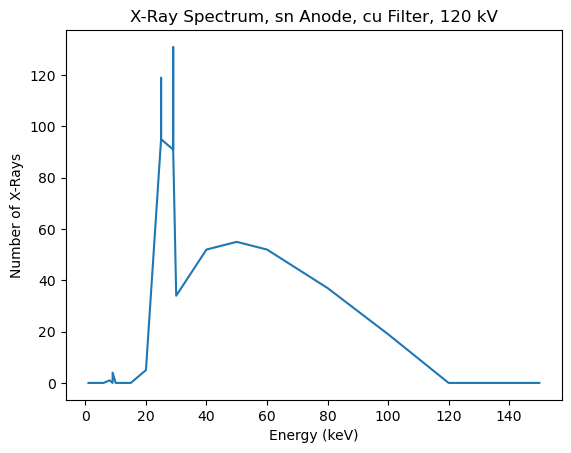

In [51]:
#anode, filter, kV
MEE, xraystot, etot = buildSpectra(anode, filter, kV)

#plot the spectra
plt.plot(etot, xraystot)
plt.title("X-Ray Spectrum, " + anode + " Anode, " + filter + " Filter, " + str(kV) + " kV")
#axis labels
plt.xlabel("Energy (keV)")
plt.ylabel("Number of X-Rays")
plt.show()



### Step 2b: Calculating mass attenuation coefficients for the phantom tissues

Using online databases, we can use known mass attenuation values to create a curve that will allow us to calculate the mass attenuation coefficients for the phantom tissues at any given energy.

In [52]:
# mass attenuation coefficient data from online for the curve fitting
brain_grey_white_matter_energies = np.array([4, 10, 20, 30, 40, 100])
brain_grey_white_matter_mass_atten = np.array([82, 5.4, .828, .381, .2701, .1701])

blood_energies = np.array([4, 10, 20, 30, 40, 100])
blood_mass_atten = np.array([82, 5.5, .843, .385, .272, .170])

bone_energies =  np.array([6, 10, 20, 30, 40, 100, 200])
bone_mass_atten = np.array([117, 28.5, 4.0, 1.33, .666, .186, .1309])

air_energies = np.array([4, 10, 20, 30, 40, 100])
air_mass_atten = np.array([77.8, 5.12, .778, .354, .249, .154])

skeletal_muscle_energies = np.array([4, 10, 20, 30, 40, 100])
skeletal_muscle_mass_atten = np.array([81.3, 5.36, .821, .378, .269, .169])

soft_tissue_energies = np.array([4, 10, 20, 30, 40, 100])
soft_tissue_mass_atten = np.array([81.6, 5.38, .823, .379, .269, .169])

lung_tissue_energies = np.array([4, 10, 20, 30, 40, 100])
lung_tissue_mass_atten = np.array([83.1, 5.46, .832, .382, .270, .170])

breast_tissue_energies = np.array([4, 10, 20, 30, 40, 100])
breast_tissue_mass_atten = np.array([66,  4.295, .6889, .3403, .2530, .1688])

tumor_energies = np.array([4, 10, 20, 30, 40, 100])
tumor_mass_atten = soft_tissue_mass_atten

In [53]:
 # getting mass attenuation curve

def func(x, c,d,e):
    return np.power(x, -c)*np.exp(-e)+d

def mass_atten_curve(Energydata, MassAttendata):
    popt, pcov = curve_fit(func, Energydata, MassAttendata)
    Energy=np.arange(1, 100, 1)
    MassAttenuationSim=func(Energy, *popt)
    return MassAttenuationSim
    """
    plt.plot(Energy, MassAttenuationSim, 'k')
    plt.plot(Energydata,MassAttendata, 'r.')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Mass Attenuation Coefficient (cm^2/g)')
    plt.title('Modeling mass attenuation coefficients')
    """

brain = mass_atten_curve(brain_grey_white_matter_energies, brain_grey_white_matter_mass_atten)
blood = mass_atten_curve(blood_energies, blood_mass_atten)
bone = mass_atten_curve(bone_energies, bone_mass_atten)
air = mass_atten_curve(air_energies, air_mass_atten)
muscle = mass_atten_curve(skeletal_muscle_energies, skeletal_muscle_mass_atten)
tissue = mass_atten_curve(soft_tissue_energies, soft_tissue_mass_atten)
lung = mass_atten_curve(lung_tissue_energies, lung_tissue_mass_atten)
breast = mass_atten_curve(breast_tissue_energies, breast_tissue_mass_atten)
tumor = mass_atten_curve(tumor_energies, tumor_mass_atten)

/var/folders/35/55pywq_d3yl8xk9f4ln94g2r0000gn/T/ipykernel_6136/1090208264.py:4: RuntimeWarning: overflow encountered in exp
  return np.power(x, -c)*np.exp(-e)+d
/var/folders/35/55pywq_d3yl8xk9f4ln94g2r0000gn/T/ipykernel_6136/1090208264.py:4: RuntimeWarning: invalid value encountered in multiply
  return np.power(x, -c)*np.exp(-e)+d
/var/folders/35/55pywq_d3yl8xk9f4ln94g2r0000gn/T/ipykernel_6136/1090208264.py:4: RuntimeWarning: overflow encountered in power
  return np.power(x, -c)*np.exp(-e)+d
/var/folders/35/55pywq_d3yl8xk9f4ln94g2r0000gn/T/ipykernel_6136/1090208264.py:4: RuntimeWarning: overflow encountered in multiply
  return np.power(x, -c)*np.exp(-e)+d


Display the mass attenuation coefficients for the phantom tissues at different energies

In [54]:
#graphing the attenuation coefficients
import matplotlib.pyplot as plt
fig, ((ax1, ax2, ax3, ax4, ax5), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2, 5, figsize=(30, 10))

# Data
data = [brain, blood, bone, air, muscle, tissue, lung, breast, tumor]
Energy=np.arange(1, 100, 1)
titles = ["Brain", "Blood", "Bone", "Air", "Muscle", "Tissue", "Lung", "Breast", "Tumor"]
for ax, d, title in zip((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9), data, titles):
    ax.plot(Energy, d)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Energy (keV)')
    ax.set_ylabel('Mass Attenuation Coefficient (cm^2/g)')
    ax.set_title(title)
plt.show()

We curve fit the coefficients for each of the different tissue types to an exponential decay model as we did in HW 2B. All coefficients were taken from: https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html. When we plot each of the curves, they appear as expected relative to one another. The coefficients for bone were the highest, as bone will attenuate the most Xrays. Since the coefficients for bone were so high, we had to adjust the points we chose in order for the curve fitting model to work properly. We also assumed that the mass attenuation curve for tumors was the same as that of soft tissue. In Beer Lambert's law, when we convert the mass attenuation coefficients to linear attenuation coefficients, we account for the higher density of the tumor compared to soft tissue.

Using the mean effective energy calculated above, we can now calculate the mass attenuation coefficients for the phantom tissues.

In [55]:
 # find mass attenuation

def mass_atten_coefficients(energy):
    energy = int(energy)
    mass_atten_coeffs = np.zeros(9)
    mass_atten_coeffs[0] = brain[energy]
    mass_atten_coeffs[1] = blood[energy]
    mass_atten_coeffs[2] = bone[energy]
    mass_atten_coeffs[3] = air[energy]
    mass_atten_coeffs[4] = muscle[energy]
    mass_atten_coeffs[5] = tissue[energy]
    mass_atten_coeffs[6] = lung[energy]
    mass_atten_coeffs[7] = breast[energy]
    mass_atten_coeffs[8] = tumor[energy]
    return mass_atten_coeffs

mass_atten_coefficients(MEE)

array([0.33838076, 0.34210028, 1.1707896 , 0.31358511, 0.33592632,
       0.33640645, 0.33882768, 0.30450344, 0.33640645])

### Step 2c: Do Beer lambert law to find the attenuation of the x-ray beam as it passes through the phantom

In [56]:
##beer lambert law
def linear_atten_coefficients(energy): #convert to linear attenuation
    #material densities from Harvard bionumbers table
    energy = int(energy)
    linear_atten_coeffs = np.zeros(9)
    linear_atten_coeffs[0] = brain[energy] * 1.05 
    linear_atten_coeffs[1] = blood[energy]  * 1.06 
    linear_atten_coeffs[2] = bone[energy] * 1.920 
    linear_atten_coeffs[3] = air[energy] *.001 
    linear_atten_coeffs[4] = muscle[energy] *1.05 
    linear_atten_coeffs[5] = tissue[energy] *0.950 
    linear_atten_coeffs[6] = lung[energy] *1.11 
    linear_atten_coeffs[7] = breast[energy] * 0.978
    linear_atten_coeffs[8] = tumor[energy] * 1.8

    return linear_atten_coeffs

def beer_law(coeffs): #input linear attenuation coefficients
    #N/N0 = np.exp(-mu*deltax), gives the percentage of Xrays passed
    beers = np.zeros(9)
    for j in range(len(beers)):
        pixel_size = object_width/256
        beers[j] = np.exp(-coeffs[j]*pixel_size) #assuming that one pixel = pixel_size
 
    return beers #returns the percentage of rays passed, can change the fluence as needed

linear_coeffs = linear_atten_coefficients(MEE)
rays_passed = beer_law(linear_coeffs)
print(rays_passed)

[0.9658978  0.96520697 0.80290165 0.99996938 0.96614093 0.96927241
 0.96393791 0.97133637 0.94258051]


## Step 3: Process the phantom

#### Seperating tissues to apply Beer Lambert's Law to the image

Getting the image

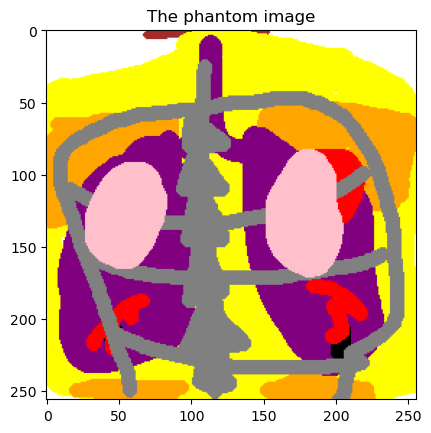

In [57]:
#load the image and display it 
img = mpimg.imread('image.png')
imgplot = plt.imshow(img)
plt.title('The phantom image')
plt.show()

#function to convert the image to grayscale 
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Isolating images and setting percent of x-rays that will make it through

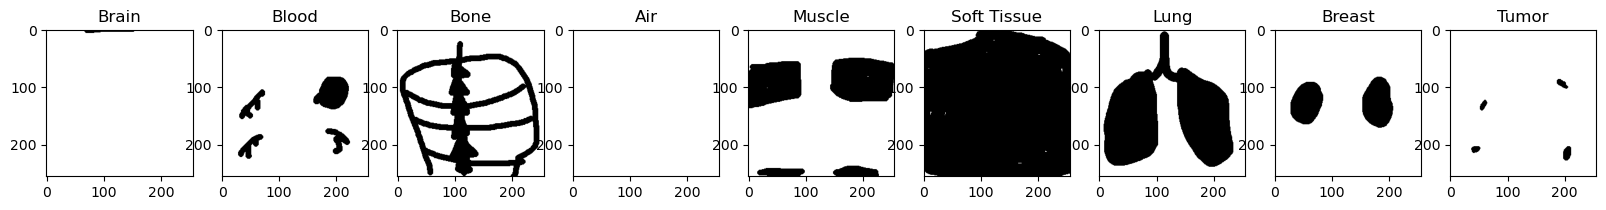

In [58]:
#all white square
white_image = np.ones((256, 256))

def convert_to_gray(img, rays_passed, red, green, blue):
    flag = False
    gray = np.ones((256, 256))    
    for i in range(256):
        for j in range(256):
            try:
                r,g,b = img[i,j]
            except:
                r,g,b,a = img[i,j]
            r = int(r*255)
            g = int(g*255)
            b = int(b*255)
            if not(r == red and g == green and b == blue):
                gray[i,j] = 1
            else:
                gray[i,j] = rays_passed
    return gray

#load each color image and convert it to grayscale
try:
    brain_gray = convert_to_gray(mpimg.imread('brain_image.png'), rays_passed[0], 165, 42, 42)
except:
    brain_gray = white_image
    print("no brain tissue found")

try:
    blood_gray = convert_to_gray(mpimg.imread('blood_image.png'), rays_passed[1], 255, 0, 0)
except:
    blood_gray = white_image
    print("no blood found")

try:
    bone_gray = convert_to_gray(mpimg.imread('bone_image.png'), rays_passed[2], 128, 128, 128)
except:
    bone_gray = white_image
    print("no bone found")

try:
    air_gray = convert_to_gray(mpimg.imread('air_image.png'), rays_passed[3], 255, 255, 255)
except:
    air_gray = white_image
    print("no air found")

try:
    muscle_gray = convert_to_gray(mpimg.imread('muscle_image.png'), rays_passed[4], 255, 165, 0)
except:
    muscle_gray = white_image
    print("no muscle found")

try:
    tissue_gray = convert_to_gray(mpimg.imread('tissue_image.png'), rays_passed[5], 255, 255, 0)
except:
    tissue_gray = white_image
    print("no soft tissue found")

try:
    lung_gray = convert_to_gray(mpimg.imread('lung_image.png'), rays_passed[6], 128, 0, 128)
except:
    lung_gray = white_image
    print("no lung tissue found")

try:
    breast_gray = convert_to_gray(mpimg.imread('breast_image.png'), rays_passed[7], 255, 192, 203)
except:
    breast_gray = white_image
    print("no breast tissue found")

try:
    tumor_gray = convert_to_gray(mpimg.imread('tumor_image.png'), rays_passed[8], 0, 0, 0)
except:
    tumor_gray = white_image
    print("no tumor found")

#display the images in a 1x9 grid
fig, axs = plt.subplots(1, 9, figsize=(20, 8))

axs[0].imshow(brain_gray, cmap='gray')
axs[0].set_title('Brain')
axs[1].imshow(blood_gray, cmap='gray')
axs[1].set_title('Blood')
axs[2].imshow(bone_gray, cmap='gray')
axs[2].set_title('Bone')
axs[3].imshow(air_gray, cmap='gray', vmin=0, vmax=1)
axs[3].set_title('Air')
axs[4].imshow(muscle_gray, cmap='gray')
axs[4].set_title('Muscle')
axs[5].imshow(tissue_gray, cmap='gray')
axs[5].set_title('Soft Tissue')
axs[6].imshow(lung_gray, cmap='gray')
axs[6].set_title('Lung')
axs[7].imshow(breast_gray, cmap='gray')
axs[7].set_title('Breast')
axs[8].imshow(tumor_gray, cmap='gray')
axs[8].set_title('Tumor')
plt.show()


We separate the image drawn into the different tissue types and individually set the percent of xrays that will make it through each tissue type. We apply the values calculated with Beer Lambert law to each tissue type and multiply the percentages of xrays that make it through each tissue type to get the final attenuation of the x-ray beam through each pixel of the phantom. This allows us to see which tissues have the greatest effect on the x-ray beam and also allows us to see potential effects of beam hardening where you cannot see a spefici tissue type because another tissue type with a higher mass attenuation coefficient is blocking it.

Getting grayscale

In [73]:
#multiply the grayscale images together to get the phantom
phantom = brain_gray * blood_gray * bone_gray * air_gray * muscle_gray * tissue_gray * lung_gray * breast_gray * tumor_gray

#display the phantom
plt.imshow(phantom, cmap = plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('The phantom image in grayscale- ' 
          'using multiplied mass attenuation coefficient: '+ str(round(MEE,2)) + ' keV')
plt.colorbar()
plt.show()

#remove all image files in the current directory - to prevent overcrowding of the directory
if not save_images:
    files = glob.glob('*.png')
    for f in files:
        os.remove(f)

#### Phantom through source function

We chose to use a Gaussian blur for our source function since the vast majority of x-ray tubes produce that kind of blur. We allow the use to set the exponential decay constant for the Gaussian blur. We then apply the source function to the phantom and display the image. A smaller exponential decay constant will result in a blurrier image, while a larger exponential decay constant will result in a sharper image. This is because a smaller exponential decay constant will cause the spatial domain of the source function to be wider, while a larger exponential decay constant will make it narrower.

In [60]:
#using source function from HW2B
def sourceblur(M, x,y,a):
    #Assume source blur is 2D Gaussian function with e^{-pi (ax)^2-pi (ay)^2}
    #Use formula from class s(-M/m x0)*h_d(Mx0), i.e. this part creates s(-M/m x0)
    m=M-1
    source_o=np.exp(-np.pi*(a*-M/m*x)**2-np.pi*(a*-M/m*y)**2)
    return source_o

In [61]:
def convolve (f1, f2):
    convolve = signal.convolve2d(f1, f2, mode='same')
    return convolve

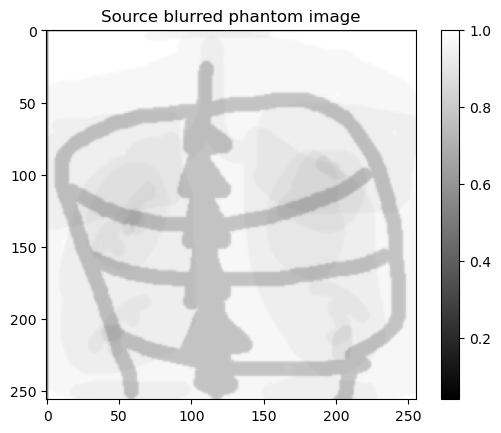

In [62]:
x_range =np.arange(-phantom_width/2,phantom_width/2,1)
y_range = np.arange(-phantom_height/2,phantom_height/2,1)
x,y = np.meshgrid(x_range,y_range)

M = (source_distance+detector_distance)/source_distance #M value for the source/detector setup
source_blur = source_a#source blur value

#convolve the source with the phantom
source_blur_phantom = convolve(phantom, sourceblur(M,x,y,source_blur))
#reduce the max value to 1
source_blur_phantom = source_blur_phantom/np.max(source_blur_phantom)

#plot the convolved image
plt.imshow(source_blur_phantom, cmap = plt.get_cmap('gray'))
plt.title('Source blurred phantom image')
plt.colorbar()
plt.show()



#### Add some noise

We used poisson noise to simulate the noise that would be present in an x-ray image. The fluence of the x-ray beam is proportional to the number of xrays that make it through the phantom. These are typically distributed in a poisson pattern. This also means that we make all pixel values integers since you cannot have half an x-ray. The higher the fluence, the less noise there will be in the image since more x-rays will make it through. We allow the user to set the fluence of the x-ray beam through the parameter lambda.

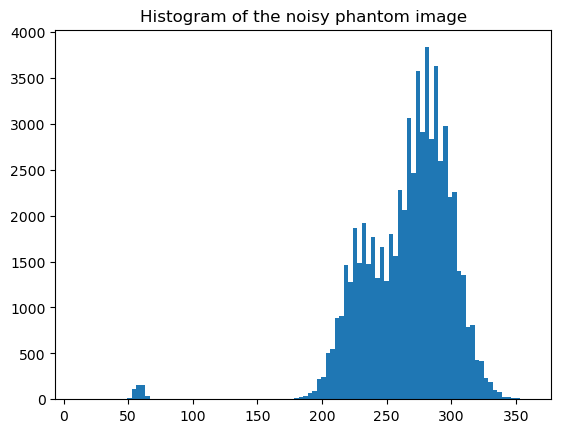

In [63]:
#using poisson noise

Lambda = fluence_lambda #average number of x-rays per pixel
poisson = np.random.poisson(Lambda, phantom.shape)

# #plot the poisson noise
# plt.imshow(poisson, cmap = plt.get_cmap('gray'))
# plt.title('Poisson noise')
# plt.show()

#add the poisson noise to the image
noisy_phantom = np.multiply(source_blur_phantom, poisson)
noisy_phantom = np.round(noisy_phantom)

#plot the noisy image
plt.imshow(noisy_phantom, cmap = plt.get_cmap('gray'))
plt.title('Noisy phantom image (lambda = %d)' % Lambda)
plt.colorbar()
plt.show()

# #plot histogram of the noisy image
plt.hist(noisy_phantom.flatten(), bins=100)
plt.title('Histogram of the noisy phantom image')
plt.show()

#### Add detector blur

The last step of the process is adding detector blur. We have two ways to specify the detector blur: a Gaussian blur and a rect blur. We allow the user to set the exponential decay constant for the Gaussian blur and the size of the rect blur. We then apply the detector blur to the image and display the final image. A smaller exponential decay constant for the Gaussian blur will result in a blurrier image, while a larger exponential decay constant will result in a sharper image. A smaller rect size will result in a sharper image, while a larger rect blur size will result in a blurrier image. This will blur the noise as well.

In [64]:
def detectblur(M, x,y,a, rect, width):
    if rect:
        detect_o = np.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if abs(M*x[i][j]) <= width/2 and abs(M*y[i][j]) <= width/2:
                    detect_o[i][j] = 1
    else:
        detect_o=np.exp(-np.pi*(a*M*x)**2-np.pi*(a*M*y)**2)
    return detect_o

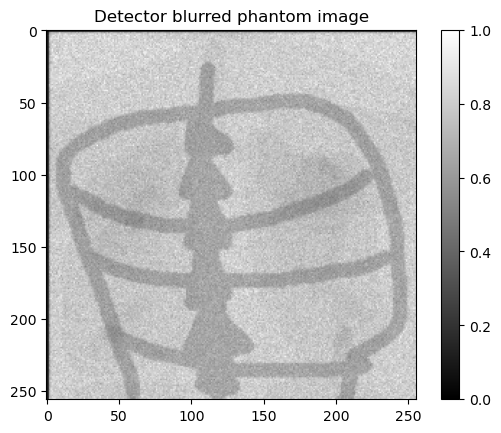

In [65]:
detector_blur = detector_a #detector blur value
width = detector_crystal_width #width of the detector crystal

#convolve the detector with the source blurred phantom
blur_phantom = convolve(noisy_phantom,detectblur(M,x,y,detector_blur, structured_detector, width))
#reduce the max value to 1
blur_phantom = blur_phantom/np.max(blur_phantom)

#plot the convolved image
plt.imshow(blur_phantom, cmap = plt.get_cmap('gray'))
plt.title('Detector blurred phantom image')
plt.colorbar()
plt.show()



## Displaying all Results

#### All results:

The results we chose to display are a quick way to visualize each step in processing the made phantom. We display the original phantom, the x-ray spectrum graph, the phantom with applied mass attenuation coefficients, the phantom with the source function applied, the phantom with noise added, the noise histogram, and the final image with detector blur applied. We also invert the image at the end to show what the clinical x-ray would look like (where white indicates less attenuation and black indicates more attenuation).

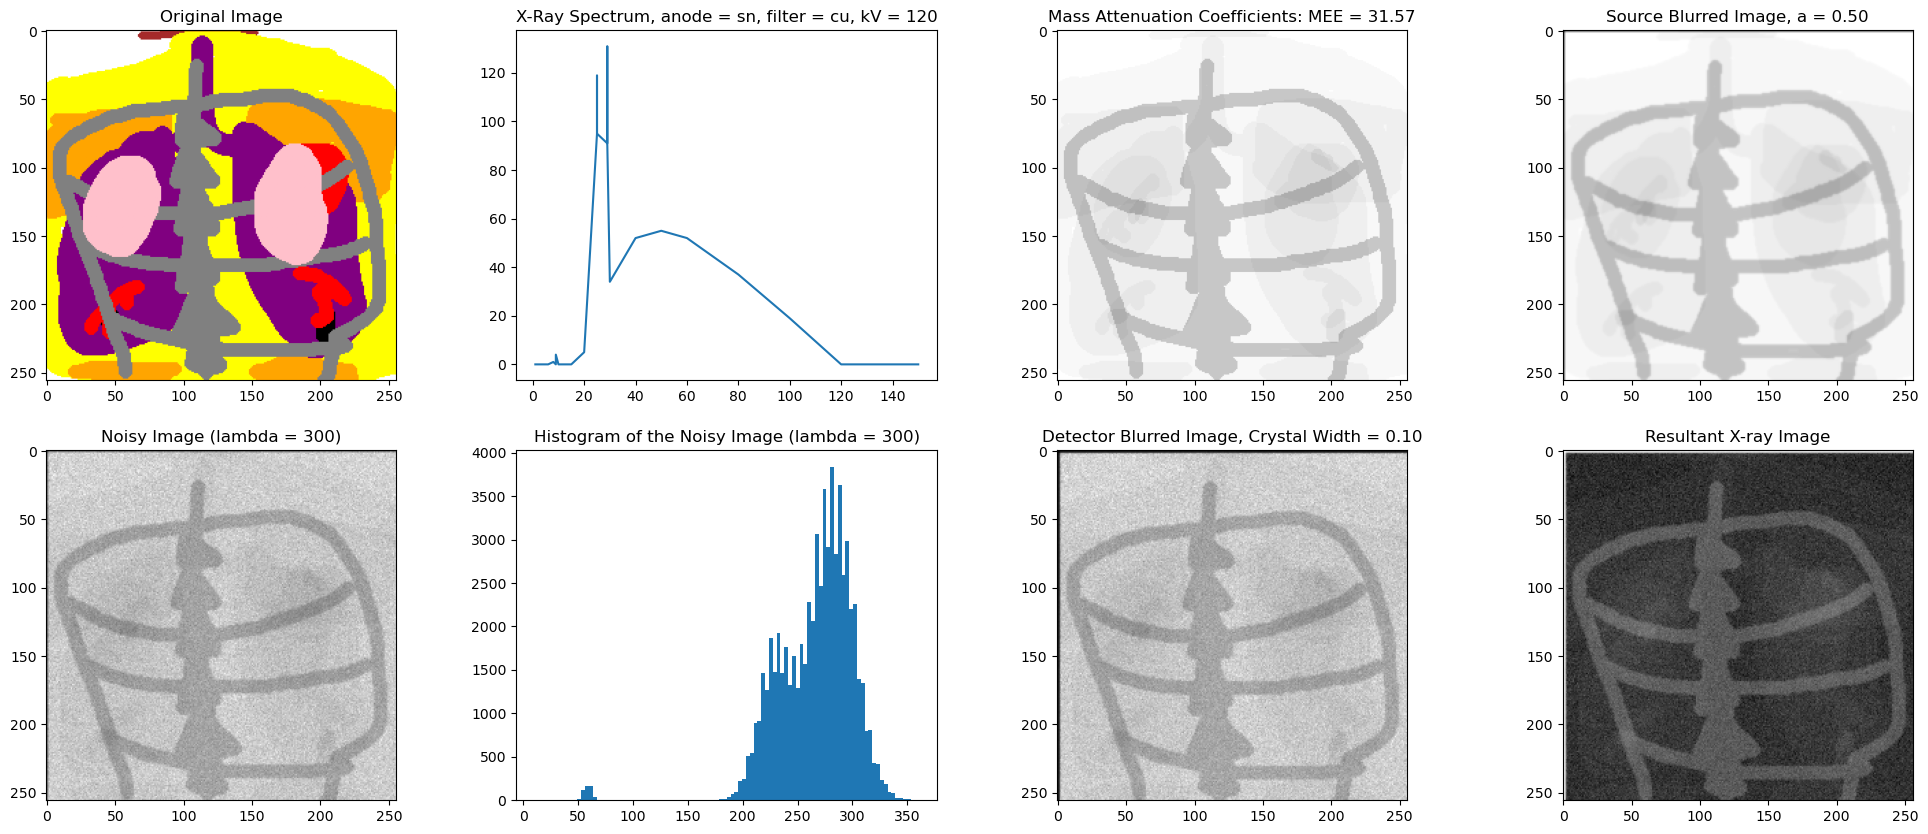

Extra info:
M =  6.0
Patient width =  25


In [66]:
# display everything in a 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

#first show original image (img)
axs[0, 0].imshow(img)
axs[0, 0].set_title('Original Image')

#second show MEE curve 
axs[0, 1].plot(etot, xraystot)
axs[0, 1].set_title('X-Ray Spectrum, anode = %s, filter = %s, kV = %d' % (anode, filter, kV))

#second show phantom image
axs[0, 2].imshow(phantom, cmap = plt.get_cmap('gray'), vmin=0, vmax=1)
axs[0, 2].set_title('Mass Attenuation Coefficients: MEE = %.2f' % MEE)

#third show source blurred phantom image
axs[0, 3].imshow(source_blur_phantom, cmap = plt.get_cmap('gray'))
axs[0, 3].set_title('Source Blurred Image, a = %.2f' % source_blur)

#fourth show noisy phantom image
axs[1, 0].imshow(noisy_phantom, cmap = plt.get_cmap('gray'))
axs[1, 0].set_title('Noisy Image (lambda = %d)' % Lambda)

#fifth show histogram of the noisy phantom image
axs[1, 1].hist(noisy_phantom.flatten(), bins=100)
axs[1, 1].set_title('Histogram of the Noisy Image (lambda = %d)' % Lambda)

#sixth show detector blurred phantom image
axs[1, 2].imshow(blur_phantom, cmap = plt.get_cmap('gray'))
if structured_detector:
    axs[1, 2].set_title('Detector Blurred Image, Crystal Width = %.2f' % detector_crystal_width)
else:
    axs[1, 2].set_title('Detector Blurred Image, a = %.2f' % detector_blur)

#next show inverted image
inverted_image = np.ones((256, 256)) - blur_phantom
axs[1, 3].imshow(inverted_image, cmap = plt.get_cmap('gray'))
axs[1, 3].set_title('Resultant X-ray Image')
plt.show()

print("Extra info:")
print("M = ", M)
print("Patient width = ", object_width)


#### Just the x-ray result

In [67]:
plt.imshow(inverted_image, cmap = plt.get_cmap('gray'))
plt.title('Resultant X-ray Image')
plt.show()